In [56]:
from wigner_functions import *
import h5py
from scipy.sparse import *
import zarr

In [57]:
import time

In [58]:
lmax=3000 #1e4
wlmax=5e2
lmax=np.int(lmax+1)
wlmax=np.int(wlmax+1)

In [59]:
ncpu=8
l_step=10 #not used with dask
w_l=np.arange(wlmax+1)
l=np.arange(lmax+1)

In [60]:
??LocalCluster

Object `LocalCluster` not found.


In [72]:
import dask
import dask.array as da
from dask import delayed

from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=1,processes=False,memory_limit='10gb',threads_per_worker=8,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms',scheduler_port=12234,diagnostics_port=8800)#dashboard_address='localhost:8787')
client=Client(LC,asynchronous=False)

In [61]:
def wigner_3j_asym(j_1,j_2,j_3,m_1,m_2,m_3): #assume j1,j2>>j3.... wiki
    sj=(j_1+j_2+1)
    th=np.arccos((m_1-m_2)/sj)
    wd=wigner_d(m_3,j_2-j_1,np.atleast_1d(th),j_3)[0,0]
    print(wd)
    return ((-1)**(j_2+m_2))*wd/np.sqrt(sj)

In [62]:
def wigner_3j_asym_H(j_1,j_2,j_3,m_1,m_2,m_3): #j1+j2+j3>>1, m1=m2=m3=0.. Hivon
    wj=2*(j1*j2)**2
    wj+=2*(j2*j3)**2
    wj+=2*(j1*j3)**2
    wj-=j1**4+j2**4+j3**4
    wj=wj**(-0.5)
    wj*=2./np.pi
    return np.sqrt(wj)*(-1)**((j_1+j_2+j_3)/2)

def wigner_3j_asym_H2(j_1,j_2,j_3,m_1,m_2,m_3): #j1+j2+j3>>1, m1=m2=m3=0.. Hivon
    J=j_1+j_2+j_3
    logwj=log_factorial(J/2)
    logwj-=log_factorial(J/2-j_1)
    logwj-=log_factorial(J/2-j_2)
    logwj-=log_factorial(J/2-j_3)
    logwj-=0.5*log_factorial(J+1)
    logwj+=0.5*log_factorial(J-2*j_1)
    logwj+=0.5*log_factorial(J-2*j_2)
    logwj+=0.5*log_factorial(J-2*j_3)
    return (-1)**(J/2)*np.exp(logwj)

In [63]:
def wig3j_map(m1,m2,m3,j1,j2,j3,asym_fact=np.inf):
#     n1=len(l)
#     n2=len(l)
#     n3=len(j3)

#     c=np.array(list(Comb(l,l,j3)))
# #     print(c.shape)
#     j_max=np.amax(l.max()+l.max()+l.max()+1)
#     _calc_factlist(j_max)
#     d_mat=client.gather(client.map(partial(wigner_3j_3, m_1, m_2, m_3),c))
#     d_mat=np.array(d_mat).reshape(n1,n2,n3)
    print('w3j_map doing ',np.atleast_1d(j3)[0])
    xx=Wigner3j_parallel( m1, m2, m3,np.atleast_1d(j1), np.atleast_1d(j2) ,np.atleast_1d(j3),ncpu=1,
                             asym_fact=asym_fact)

    return xx


# dst=client.map(wig3j_map,w_l)

In [64]:
def Wigner3j_parallel2( m_1, m_2, m_3,j_1, j_2, j_3,ncpu=None,asym_fact=np.inf):
    if ncpu is None:
        ncpu=cpu_count()-2
    p=Pool(ncpu)

    j_max=np.amax(j_1.max()+j_2.max()+j_3.max()+1)
#     _calc_factlist(j_max)

    n1=len(j_1)
    n2=len(j_2)
    n3=len(j_3)

    c=np.array(np.meshgrid(j_1,j_2,j_3,indexing='ij')).T.reshape(-1,3) #only needed to put cuts below. Otherwise Comb is better

    x=c[:,0]+c[:,1]-c[:,2]>=0
    x*=c[:,0]-c[:,1]+c[:,2]>=0
    x*=-c[:,0]+c[:,1]+c[:,2]>=0
    
    x*=abs(m_1) <= c[:,0]
    x*=abs(m_2) <= c[:,1]
    x*=abs(m_3) <= c[:,2]
    
    if m_1==0 and m_2==0 and m_3==0:
        x*=(c[:,0]+c[:,1]+c[:,2])%2==0

    c=c[x]
    
    
    d_mat=p.map(partial(wigner_3j_3,asym_fact, m_1, m_2, m_3),c,chunksize=100)
    p.close()
    
    dd=np.zeros((n1,n2,n3))
    indx1=np.searchsorted(j_1,c[:,0])
    indx2=np.searchsorted(j_2,c[:,1])
    indx3=np.searchsorted(j_3,c[:,2])
    dd[indx1,indx2,indx3]=d_mat
    
    return dd

In [65]:
asym_fact=100

In [66]:
# if lmax>500:
#     fname='temp/dask_wig3j_big_{i}.zarr'
# else:
#     fname='temp/dask_wig3j_test_{i}.zarr'
fname='temp/dask_wig3j_l{lmax}_w{wlmax}_{i}.zarr'
if asym_fact is not np.inf:
    fname='temp/dask_wig3j_l{lmax}_w{wlmax}_{i}_asym'+str(asym_fact)+'.zarr'

In [67]:
fname,lmax,wlmax

('temp/dask_wig3j_l{lmax}_w{wlmax}_{i}_asym100.zarr', 3001, 501)

In [75]:
step=100#np.int(min(5e3,lmax/10))
lb=np.arange(lmax+1,step=step)
lb[-1]=lmax
# lb=np.sort(np.unique(np.append([0,100,lmax],np.arange(100,lmax,step))))
lb,lb.shape

(array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
        1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
        2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3001]), (31,))

In [68]:
j3_b=np.arange(0,50+1,step=10)
j3_b[-1]=50
j3_b

array([ 0, 10, 20, 30, 40, 50])

In [76]:
w_l

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [77]:
m1=0
m2=0
m3=0
# arrs=[da.from_delayed(delayed(wig3j_map)(m1,m2,m3,l,l,np.atleast_1d(j3),asym_fact),shape=(lmax,lmax),dtype='float32') for j3 in w_l]

arrs=[da.hstack([da.vstack([da.from_delayed(delayed(wig3j_map)(m1,m2,m3,l[lb[i]:lb[i+1]],l[lb[k]:lb[k+1]],
                                                               np.atleast_1d(j3),asym_fact),
                    shape=(lb[i+1]-lb[i],lb[k+1]-lb[k]),dtype='float32') 
                    for i in np.arange(len(lb)-1)]) 
                     for k in np.arange(len(lb)-1)])
                      for j3 in w_l]
arrs2=da.stack(arrs)
arrs2=arrs2.rechunk(chunks=(1,1000,1000))

%time arrs2.to_zarr(fname.format(i=0,lmax=lmax,wlmax=wlmax), overwrite=True)

KeyboardInterrupt: 

In [14]:
def A_J(j,j2,j3,m2,m3):
    out=j**2-(j2-j3)**2
    out*=(j2+j3+1)**2-j**2
    out*=j**2-(m2+m3)**2
    x=out<0
    out[x]=0
    return out**0.5

def B_J(j,j2,j3,m2,m3):
    out=(m2+m3)*(j2*(j2+1)-j3*(j3+1)+j*0)-(m2-m3)*j*(j+1)
    out*=2*j+1
    return out

def X_Np1(j,j2,j3,m2,m3): #X_n+1
    return j*A_J(j+1,j2,j3,m2,m3)

def X_N(j,j2,j3,m2,m3): #X_n+1
    return B_J(j,j2,j3,m2,m3)

def X_Nm1(j,j2,j3,m2,m3): #X_n+1
    return (j+1)*A_J(j,j2,j3,m2,m3)


def wig3j_recur_vec(j1b,j2b,m1,m2,m3,j3_outmax,step,jmax,z1=None):
#     assert m3==-m1-m2
    j1=np.arange(j1b,j1b+step)
    j1=j1[j1<=lmax]
    j2=np.arange(j2b,j2b+step)
    j2=j2[j2<=lmax]

    j1=j1.reshape(len(j1),1,1)
    j2=j2.reshape(1,len(j2),1)

    j3_min=np.absolute(j1-j2)
    j3_max=(j1+j2+1) #j3_max is j1+j2, +1 for 0 indexing
    
    nj3=np.amax(j3_max)
    
    j3=np.arange(nj3).reshape(1,1,nj3)
    print(j3_outmax)
    if j3_outmax is None:
        j3_outmax=np.amax(j3)

    wig_out=np.zeros((j1.shape[0],j2.shape[1],max(j3_outmax,np.amax(j3_max))),dtype='float32')
    
    for i1 in np.arange(j1.shape[0]):
        for i2 in np.arange(j2.shape[1]):
            wig_out[i1,i2,j3_min[i1,i2,0]]=np.float32(wigner_3j_2(j1[i1,0,0],j2[0,i2,0],j3_min[i1,i2,0],m1,m2,m3))
            wig_out[i1,i2,j3_min[i1,i2,0]+1]=np.float32(wigner_3j_2(j1[i1,0,0],j2[0,i2,0],j3_min[i1,i2,0]+1,m1,m2,m3))

    x_Np1=X_Np1(j3,j2,j1,m1,m2)*-1 #j==j3
    x_N=X_N(j3,j2,j1,m1,m2) #j==j3
    x_Nm1=X_Nm1(j3,j2,j1,m1,m2) #j==j3
    
    for i in np.arange(nj3-1):        
        x=j3[0,0,i+1]>j3_min+1
        x*=j3[0,0,i+1]<j3_max
        x=x[:,:,0]
        x*=x_Np1[:,:,i]!=0
        A=(x_Nm1[:,:,i]*wig_out[:,:,j3[0,0,i-1]]+x_N[:,:,i]*wig_out[:,:,j3[0,0,i]])/x_Np1[:,:,i]
        A[~x]=0
#         A=np.nan_to_num(A)
        wig_out[:,:,j3[0,0,i+1]]+=A
#         print(wig_out)

    #norm??
#     wig_out=np.nan_to_num(wig_out)
    
    wig_out=wig_out[:,:,:j3_outmax]
    if z1 is not None:
        z1[np.amin(j1):np.amax(j1)+1,np.amin(j2):np.amax(j2)+1,:]+=wig_out
        z1[np.amin(j2):np.amax(j2)+1,np.amin(j1):np.amax(j1)+1,:]+=wig_out.transpose(1,0,2)
    else:
        return wig_out

In [15]:
from multiprocessing import Pool
def wig3j_recur_1d(j2s,m1,m2,m3,j3_outmax,j1):
    out_ij={}
    x=j2s<=j1
    for j2 in j2s[x]:
#         print('doing ',j1,j2)
        out_ij[j2]=wig3j_recur(j1,j2,m1,m2,m3,j3_outmax=j3_outmax)
#         print('done ',j1,j2)
    return out_ij

def wig3j_recur_2d(j1b,j2b,m1,m2,m3,j3_outmax,step,z1_out):
    try:
        out= np.zeros((min(step,lmax-j1b),min(step,lmax-j2b),j3_outmax))
    except Exception as err:
        print(err, step,lmax, j1b,j2b)
        crash 
    j1s=np.arange(j1b,min(lmax,j1b+step))
    j2s=np.arange(j2b,min(lmax,j2b+step))
    out_ij={}
    t1=time.time()
    funct=partial(wig3j_recur_1d, j2s,m1,m2,m3,j3_outmax)
    pool=Pool(10)
    out_ij=pool.map(funct,j1s)
    pool.close()
#     for j1 in np.arange(len(j1s)):
# #         out_ij[j1]=client.submit(wig3j_recur_1d,j1s[j1],j2s,m1,m2,m3,j3_outmax)
#         out_ij[j1]=wig3j_recur_1d(j1s[j1],j2s,m1,m2,m3,j3_outmax)
        
    t2=time.time()
    for j1 in np.arange(len(j1s)):
        for j2 in np.arange(len(j2s)):
            if j2s[j2]<=j1s[j1]:
                out[j1,j2,:]=out_ij[j1][j2s[j2]]
#                 z1[j1s[j1],j2s[j2],:]=out_ij[j1][j2s[j2]][0,0,:]
#                 z1[j2s[j2],j1s[j1],:]=out_ij[j1][j2s[j2]][0,0,:]

    t3=time.time()
    z1[j1b:j1b+step,j2b:j2b+step,:]+=out
    
    for j1 in np.arange(len(j1s)):
        for j2 in np.arange(len(j2s)):
            if j2s[j2]==j1s[j1]:
                out[j1,j2,:]*=0
                
    z1[j2b:j2b+step,j1b:j1b+step,:]+=out.transpose(1,0,2)
#     z1[j1b:j1b+step,j2b:j2b+step,:]=out
#     print('done all ',j1b,j2b,t3-t2)
#     except Exception as err:
#         print(err,out.shape,j1s.shape,j2s.shape,j1b,j2b,j2,j2s[j2],step,lmax)
    return 0


In [16]:
step=10
lb=np.arange(lmax,step=step)
lb[-1]=lmax

In [17]:
z2 = zarr.open(fname.format(i=str(2)+'j3m2',lmax=lmax,wlmax=wlmax), mode='w', shape=(lmax,lmax,wlmax),
...                chunks=(lmax/10, lmax/10,wlmax/10),
               dtype='float32',overwrite=True)

/usr/lib/python3.7/site-packages/zarr/creation.py:197: UserWarning: ignoring keyword argument 'overwrite'
  warn('ignoring keyword argument %r' % k)


In [18]:
z2.

(201, 201, 51)

In [19]:
z1 = zarr.open(fname.format(i=str(2)+'j3m',lmax=lmax,wlmax=wlmax), mode='w', shape=(lmax,lmax,wlmax),
...                chunks=(lmax/10, lmax/10,wlmax/10),
               dtype='float32',overwrite=True)

In [21]:
m1=2
m2=-2
m3=0



In [31]:
lb1=100
lb2=100
%time oo2=wig3j_recur_2d(lb1,lb2,m1,m2,m3,wlmax,step,z1)
oo2=z1[:10,:10,:19]

CPU times: user 9.54 ms, sys: 59.5 ms, total: 69 ms
Wall time: 175 ms


In [32]:
np.all(oo2==oo2.transpose(1,0,2))

True

In [33]:
d=oo2-oo2.transpose(1,0,2)

In [34]:
%time oo=wig3j_recur_vec(lb1,lb2,m1,m2,m3,wlmax,step,lmax,z2)
oo=z2[:10,:10,:19]
# %time oo2=wig3j_recur(j1[0,0,0],j2[0,0,0],m1,m2,m3,j3_outmax=j3_outmax)

51
CPU times: user 371 ms, sys: 3.6 ms, total: 375 ms
Wall time: 374 ms


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide


In [43]:
np.all(oo==z1[:10,:10,:wlmax])

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [44]:
d=oo-z1[:10,:10,:wlmax]

ValueError: operands could not be broadcast together with shapes (10,10,19) (10,10,51) 

In [45]:
d.min(),d.max()

(0.0, 0.0)

In [46]:
d[2,2,2]

0.0

In [47]:
oo[2,2,2]

1.9123658

In [48]:
z1[2,2,2]/2

0.23904572427272797

In [ ]:
m1=-2
m2=2
m3=0
t0=time.time()
for lb1 in lb:
    ww_out={}
    for lb2 in lb:
        print('doing',lb1,lb2)
        t1=time.time()
        ww_out[lb2]=wig3j_recur_2d(lb1,lb2,m1,m2,m3,wlmax,step,z1)
#     ww_out=client.compute(ww_out).result()
#         ww_out[lb2]=client.submit(wig3j_recur_2d,lb1,lb2,m1,m2,m3,wlmax,step,z1)
#         ww_out[lb2]=wig3j_recur_2d(lb1,lb2,m1,m2,m3,wlmax,step)
#     for lb2 in lb:
# #         z1[lb1:lb1+step,lb2:lb2+step,:]=ww_out[lb2].result()
#         ww_out[lb2]=ww_out[lb2].result()
#         t2=time.time()
#         print('done',lb1,lb2,t2-t1)
    del ww_out
    t2=time.time()
    print('done',lb1,t2-t1)
print('done all',t2-t0)

doing 0 0
doing 0 10
doing 0 20
doing 0 30
doing 0 40
doing 0 50
doing 0 60
doing 0 70
doing 0 80
doing 0 90
doing 0 100
doing 0 110
doing 0 120
doing 0 130
doing 0 140
doing 0 150
doing 0 160
doing 0 170
doing 0 180
doing 0 190
doing 0 201
done 0 0.152998685836792
doing 10 0
doing 10 10
doing 10 20
doing 10 30


In [54]:
xx=z1[:,:,0]
# xx.transpose(1,0,2).shape

In [55]:
xx.shape

(201, 201)

In [53]:
np.all(xx==xx.T)

True

In [ ]:
crash

In [ ]:
m1=-2
m2=2
m3=0

arrs=[da.hstack([da.vstack([da.from_delayed(delayed(wig3j_recur_1d)(l[i],l[k],m1,m2,m3,
                                                               wlmax),
                    shape=(1,1,wlmax),dtype='float32') 
                    for i in np.arange(lmax+1)]) 
                     for k in np.arange(lmax+1)])
                      ]
arrs2=da.concatenate(arrs,axis=-1)
# arrs2=arrs2.rechunk(chunks=(int(lmax/1),int(lmax/1),int(wlmax)))

print(fname.format(i=str(2)+'j3m',lmax=lmax,wlmax=wlmax))
%time arrs2.to_zarr(fname.format(i=str(2)+'j3m',lmax=lmax,wlmax=wlmax),overwrite=True)

In [ ]:
arrs2.shape

In [ ]:
crash

In [ ]:
l

In [ ]:
arrs2.shape

In [ ]:
m1=-2
m2=2
m3=0

arrs=[da.hstack([da.vstack([da.from_delayed(delayed(wig3j_map)(m1,m2,m3,l[lb[i]:lb[i+1]],l[lb[k]:lb[k+1]],
                                                               np.atleast_1d(w_l[j3_b[j3]:j3_b[j3+1] ]),asym_fact),
                    shape=(lb[i+1]-lb[i],lb[k+1]-lb[k],j3_b[j3+1]-j3_b[j3]),
                                            dtype='float32') 
                    for i in np.arange(len(lb)-1)]) 
                     for k in np.arange(len(lb)-1)])
                      for j3 in np.arange(len(j3_b)-1)]
arrs2=da.concatenate(arrs,axis=-1)
arrs2=arrs2.rechunk(chunks=(lmax/10,lmax/10,wlmax/10))
# print(fname.format(i=str(2)+'j3m',lmax=lmax,wlmax=wlmax))
# %time arrs2.to_zarr(fname.format(i=str(2)+'j3m',lmax=lmax,wlmax=wlmax),overwrite=True)

In [ ]:
arrs2.shape

In [ ]:
client.restart()

In [ ]:
m1=-2
m2=2
m3=0

arrs=[da.hstack([da.vstack([da.from_delayed(delayed(wig3j_map)(m1,m2,m3,l[lb[i]:lb[i+1]],l[lb[k]:lb[k+1]],
                                                               np.atleast_1d(j3),asym_fact),
                    shape=(lb[i+1]-lb[i],lb[k+1]-lb[k],1),dtype='float32') 
                    for i in np.arange(len(lb)-1)]) 
                     for k in np.arange(len(lb)-1)])
                      for j3 in w_l]
# arrs2=da.stack(arrs)
arrs2=da.concatenate(arrs,axis=-1)
arrs2=arrs2.rechunk(chunks=(lmax/10,lmax/10,wlmax/10))
%time arrs2.to_zarr(fname.format(i=2,lmax=lmax,wlmax=wlmax),overwrite=True)

In [ ]:
crash

In [ ]:
arrs2=zarr.open(fname.format(i=2,lmax=lmax,wlmax=wlmax))

In [ ]:
arrs2.oindex[0,:,:].max()

In [ ]:
z1=zarr.open('./temp/dask_wig3j_l100_w30_0_asym50.zarr/')
z2=np.array(zarr.open('./temp/dask_wig3j_l100_w30_0.zarr/'))

In [ ]:
z1.reshape(1,3000,100)

In [ ]:
crash

In [ ]:
zaa_in=zarr.open('temp/dask_test0.zarr')

In [ ]:
np.einsum('i,ijk->jk',w_l,zaa_in)

In [ ]:
zaa_in.oindex[np.int32(w_l[:5]), [1, 3],[1,5]]

In [ ]:
zaa_in

In [ ]:
aa2 = da.from_array(zaa_in, chunks=zaa_in.chunks)

In [ ]:
aa2

In [ ]:
m_1=0
m_2=0
m_3=0
fname='temp/wigner_test_big.h5'

with h5py.File(fname,'w') as f:
    dst = f.create_dataset("0", shape=(lmax,lmax,wlmax),
                           dtype=np.float32)
    lm=0
    while lm<lmax:
        l_t=np.arange(lm,lm+l_step)
        lm2=0
        while lm2<lmax:
            if lm2>lm+l_step+wlmax or lm>lm2+l_step+wlmax:
                print(lm2,lm)
                lm2+=l_step
                continue
            l_t2=np.arange(lm2,lm2+l_step)
            dst[lm:lm+l_step,lm2:lm2+l_step,:]=Wigner3j_parallel( m_1, m_2, m_3,l_t, l_t2 , w_l,ncpu=ncpu)
            
            lm2+=l_step
            
        lm+=l_step

In [ ]:
f.close()

In [ ]:
m_1=2
m_2=-2
m_3=0

with h5py.File(fname,'a') as f:
    dst = f.create_dataset("2", shape=(lmax,lmax,wlmax),
                           dtype=np.float32)
    lm=0
    while lm<lmax:
        l_t=np.arange(lm,lm+l_step)
        lm2=0
        while lm2<lmax:
            if lm2>lm+l_step+wlmax or lm>lm2+l_step+wlmax:
                print(lm2,lm)
                lm2+=l_step
                continue
            l_t2=np.arange(lm2,lm2+l_step)
            dst[lm:lm+l_step,lm2:lm2+l_step,:]=Wigner3j_parallel( m_1, m_2, m_3,l_t, l_t2 , w_l,ncpu=ncpu)
            lm2+=l_step
        lm+=l_step

In [ ]:
f.close()

In [ ]:
fname='temp/wigner_test.h5'

In [ ]:
f = h5py.File(fname, 'r')


In [ ]:
d=f["0"]

In [ ]:
d.shape

In [ ]:
w=np.ones_like(w_l)

In [ ]:
M=np.zeros((500,500))
M2=np.zeros((500,500))
M[:,:]=np.dot(d,w)

In [ ]:
x=d[w_l[3:5],:,:]#

In [ ]:
x[:,np.int32(w_l[:5]),:]

In [ ]:
lm=0
while lm<lmax:
    M2[lm:lm+l_step,:]=np.dot(d[lm:lm+l_step,:,:],w)
    lm+=l_step

In [ ]:
np.all(M2==M)

In [ ]:
f.close()

In [ ]:
coo_matrix((100,100))

In [1]:
import zarr
from wigner_functions import *

In [2]:
fname= 'temp/dask_wig3j_l3000_w500_{m}_reorder.zarr'
m=0
wig_3j_0=zarr.open(fname.format(m=m))

In [3]:
fname= 'temp/dask_wig3j_l5000_w500_{m}_asym50.zarr'
m=0
wig_3j_00=zarr.open(fname.format(m=m),mode='r')

In [4]:
wig_3j_0,wig_3j_00

(<zarr.core.Array (501, 3001, 3001) float32>,
 <zarr.core.Array (500, 5000, 5000) float32 read-only>)

In [5]:
j1=400
j2=400
j3=10
dd=wigner_3j(j1,j2,j3,-m,m,0)
# dd0=wigner_3j_000(np.atleast_1d(j1),np.atleast_1d(j2),np.atleast_1d(j3),0,0,0)
dd2=wig_3j_0[j3,j1,j2]
dd22=wig_3j_00[j3,j1,j2]
dd0=wig3j_recur(j1,j2,-m,m,0,j3_outmax=500)
tt=wig_3j_0[j3,:,:]
tt2=wig_3j_00[j3,:3001,:3001]
tt.shape,np.all(tt==tt.T)

((3001, 3001), True)

In [6]:
np.all(np.isclose(tt,tt2))

True

In [7]:
dif=tt-tt2

In [8]:
dif.min()

0.0

In [9]:
x=dif!=0
np.argwhere(x)

array([], shape=(0, 2), dtype=int64)

[]

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


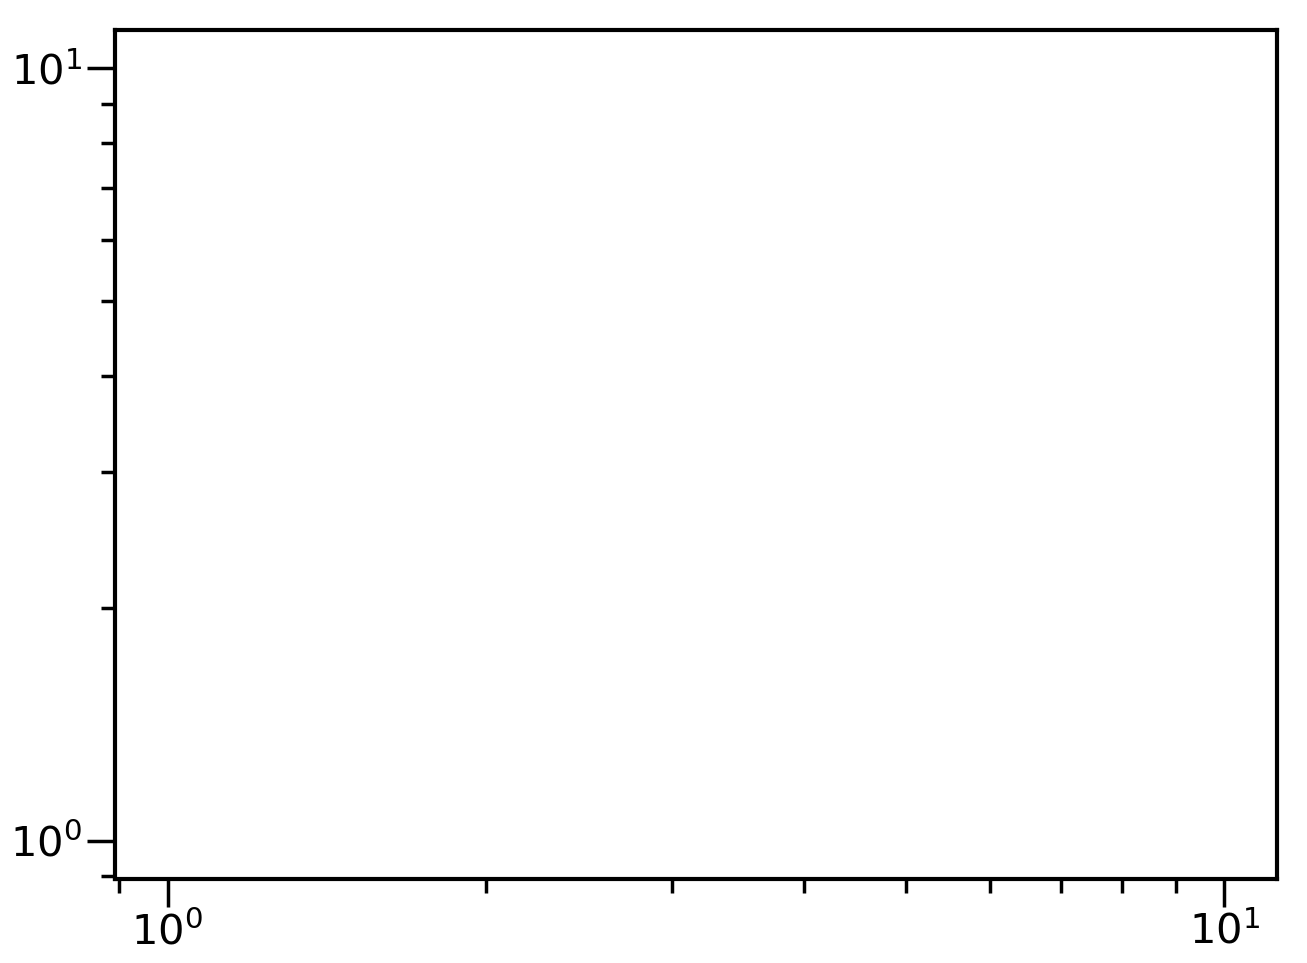

In [10]:
plot(np.argwhere(x)[:,0],np.argwhere(x)[:,1],'bo')
loglog()

In [11]:
tt[0,10],tt2[0,10]

(0.2182179, 0.2182179)

In [12]:
RR=tt[np.argwhere(x)[:,0],np.argwhere(x)[:,1]]/tt2[np.argwhere(x)[:,0],np.argwhere(x)[:,1]]

In [13]:
RR.max()

ValueError: zero-size array to reduction operation maximum which has no identity

In [14]:
tt2[np.argwhere(x)[:,0],np.argwhere(x)[:,1]]

array([], dtype=float32)

In [15]:
dd,dd2,dd22,dd0[j3]

(-324*sqrt(27115591265571340566539300506397985533305)/6135523267627915048422707,
 -0.008695668,
 -0.008695668,
 -0.008695667842722576)

In [16]:
dd.evalf()/dd2,dd22/dd2,dd0[j3]

(1.00000002681222, 1.0, -0.008695667842722576)

In [17]:
dd2

-0.008695668

In [18]:
??wigner_3j_2